# Load Tensors

In [66]:
import torch

# List of tensor paths
tensor_paths = [
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/arnold_tongues_rotation_numbers_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/dspm_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/higuchi_fractal_dimensions_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/Hurst_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/mfdfa_concatd_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/mfdfa_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/short_time_fourier_transform_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/transfer_entropy_granular_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/transfer_entropy_hemispheric_avg_input_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/transfer_entropy_regional_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/spectral_entropy_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/spectral_centroids_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/freq_max_power_tensor.pt",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/CNN/spectral_edge_freqs_tensor.pt",
]

# Initialize an empty dictionary to store the tensors and another for their shapes
tensors = {}
tensor_shapes = {}

# Load the tensors into a dictionary and collect their shapes
for path in tensor_paths:
    tensor_name = path.split('/')[-1].replace('.pt', '').replace('.pth', '')

    # Remove the 'h' from the end, if it exists
    if tensor_name.endswith("h"):
        tensor_name = tensor_name[:-1]

    # Load the tensor
    data = torch.load(path)
    tensors[tensor_name] = data

    # Check the type of the loaded data
    if isinstance(data, torch.Tensor):
        tensor_shapes[tensor_name] = data.shape
    elif isinstance(data, dict):  # Likely a state_dict
        tensor_shapes[tensor_name] = "state_dict (model parameters)"
    else:
        tensor_shapes[tensor_name] = "unknown type"

# Print the shapes of all loaded tensors
for name, shape in tensor_shapes.items():
    print(f"{name}: {shape}")

arnold_tongues_rotation_numbers_tensor: torch.Size([32, 300, 300])
dspm_tensor: torch.Size([19, 18840, 10])
higuchi_fractal_dimensions_tensor: torch.Size([1, 1, 4, 8])
Hurst_tensor: torch.Size([1, 1, 32, 1])
mfdfa_concatd_tensor: torch.Size([32, 1, 30, 2])
mfdfa_tensor: torch.Size([9, 32, 10, 1])
short_time_fourier_transform_tensor: torch.Size([32, 1001, 4229])
transfer_entropy_granular_tensor: torch.Size([4, 4])
transfer_entropy_hemispheric_avg_input_tensor: torch.Size([92, 92])
transfer_entropy_regional_tensor: torch.Size([4, 4])
spectral_entropy_tensor: torch.Size([1, 1, 32, 1])
spectral_centroids_tensor: torch.Size([1, 1, 32, 1])
freq_max_power_tensor: torch.Size([1, 1, 32, 1])
spectral_edge_freqs_tensor: torch.Size([1, 1, 32, 1])


In [67]:
# Loop through the loaded tensors to check for NaNs and Infs
for tensor_name, tensor_data in tensors.items():
    # Only perform the checks if the data is a tensor
    if isinstance(tensor_data, torch.Tensor):
        total_elements = torch.numel(tensor_data)
        
        nans_count = torch.sum(torch.isnan(tensor_data)).item()
        infs_count = torch.sum(torch.isinf(tensor_data)).item()
        
        nans_percentage = (nans_count / total_elements) * 100
        infs_percentage = (infs_count / total_elements) * 100
        
        print(f"Percentage of NaNs in {tensor_name}: {nans_percentage}%")
        print(f"Percentage of Infs in {tensor_name}: {infs_percentage}%")
    else:
        print(f"{tensor_name} is not a tensor, skipping...")

Percentage of NaNs in arnold_tongues_rotation_numbers_tensor: 0.0%
Percentage of Infs in arnold_tongues_rotation_numbers_tensor: 0.0%
Percentage of NaNs in dspm_tensor: 0.0%
Percentage of Infs in dspm_tensor: 0.0%
Percentage of NaNs in higuchi_fractal_dimensions_tensor: 0.0%
Percentage of Infs in higuchi_fractal_dimensions_tensor: 0.0%
Percentage of NaNs in Hurst_tensor: 0.0%
Percentage of Infs in Hurst_tensor: 0.0%
Percentage of NaNs in mfdfa_concatd_tensor: 0.0%
Percentage of Infs in mfdfa_concatd_tensor: 0.0%
Percentage of NaNs in mfdfa_tensor: 0.0%
Percentage of Infs in mfdfa_tensor: 0.0%
Percentage of NaNs in short_time_fourier_transform_tensor: 0.0%
Percentage of Infs in short_time_fourier_transform_tensor: 0.0%
Percentage of NaNs in transfer_entropy_granular_tensor: 0.0%
Percentage of Infs in transfer_entropy_granular_tensor: 0.0%
Percentage of NaNs in transfer_entropy_hemispheric_avg_input_tensor: 0.0%
Percentage of Infs in transfer_entropy_hemispheric_avg_input_tensor: 0.0%
Pe

# Match dimensions, reshape, and normalize

In [2]:
import torch.nn.functional as F

def preprocess_and_resize_tensor(tensor, target_shape):
    # Add missing batch and channel dimensions
    while len(tensor.shape) < 4:
        tensor = tensor.unsqueeze(0)

    # Reduce the channel dimension to 1 by taking the mean along that axis
    tensor = torch.mean(tensor, dim=1, keepdim=True)

    # Normalize
    mean = tensor.mean()
    std = tensor.std()
    if std != 0:
        tensor = (tensor - mean) / std

    # Reshape/resize to target_shape
    tensor = F.interpolate(tensor, size=target_shape[2:], mode='bilinear', align_corners=True)
    
    return tensor

target_shape = [1, 1, 32, 32]

# List of all your tensors
all_tensors = [tensors[key] for key in tensors]

# Preprocess all tensors
processed_tensors = [preprocess_and_resize_tensor(tensor, target_shape) for tensor in all_tensors]

# Store preprocessed tensors back into the `tensors` dictionary
for key, tensor in zip(tensors.keys(), processed_tensors):
    tensors[key] = tensor

# Print out the new shapes
for key in tensors.keys():
    print(f"Processed tensor {key} shape: {tensors[key].shape}")


Processed tensor arnold_tongues_rotation_numbers_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor dspm_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor higuchi_fractal_dimensions_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor Hurst_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor mfdfa_concatd_tensor shape: torch.Size([32, 1, 32, 32])
Processed tensor mfdfa_tensor shape: torch.Size([9, 1, 32, 32])
Processed tensor short_time_fourier_transform_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor transfer_entropy_granular_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor transfer_entropy_hemispheric_avg_input_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor transfer_entropy_regional_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor spectral_entropy_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor spectral_centroids_tensor shape: torch.Size([1, 1, 32, 32])
Processed tensor freq_max_power_tensor shape: torch.Size(

# CNN

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

tensor_names = [
    'arnold_tongues_rotation_numbers_tensor',
    'dspm_tensor',
    'higuchi_fractal_dimensions_tensor',
    'Hurst_tensor',
    'mfdfa_concatd_tensor',
    'mfdfa_tensor',
    'short_time_fourier_transform_tensor',
    'transfer_entropy_granular_tensor',
    'transfer_entropy_hemispheric_avg_input_tensor',
    'transfer_entropy_regional_tensor',
    'spectral_entropy_tensor',
    'spectral_centroids_tensor',
    'freq_max_power_tensor',
    'spectral_edge_freqs_tensor',
]

class BaseEmbeddingNet(nn.Module):
    def __init__(self, input_channels, conv_output_channels, reduce_to_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, conv_output_channels, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(conv_output_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_reduce = nn.Linear(conv_output_channels, reduce_to_dim)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_reduce(x)
        return x

processed_tensors_dict = {name: tensor for name, tensor in zip(tensor_names, processed_tensors)}

net_params = {name: {'input_channels': 1, 'conv_output_channels': 16, 'reduce_to_dim': 8} 
              for name in processed_tensors_dict.keys()}

# Create BaseEmbeddingNets for each tensor
embedding_nets = {name: BaseEmbeddingNet(**params) for name, params in net_params.items()}

# Move networks to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for net in embedding_nets.values():
    net.to(device)

# Create custom dataset and dataloader
class CustomDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __len__(self):
        first_tensor = next(iter(self.tensors.values()))
        return first_tensor.size(0)

    def __getitem__(self, idx):
        result = {}
        for key, val in self.tensors.items():
            if val.shape[0] > idx:
                result[key] = val[idx]
        return result

def custom_collate(batch):
    collated_batch = {}
    all_keys = set([key for item in batch for key in item.keys()])
    
    for key in all_keys:
        collated_batch[key] = torch.stack([item[key] for item in batch if key in item.keys()], dim=0)
    
    return collated_batch

# Use processed_tensors for your CustomDataset
dataset = CustomDataset(processed_tensors_dict)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)

# Collect feature embeddings
all_features = []
for i, batch in enumerate(dataloader):
    features_list = [net(batch[key].to(device, dtype=torch.float32)) for key, net in embedding_nets.items()]
    concatenated_features = torch.cat(features_list, dim=1)
    all_features.append(concatenated_features.cpu().detach())

# Convert list to tensor
all_features = torch.cat(all_features, dim=0)

# Save the feature embeddings
save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Kuramoto'
torch.save(all_features, f'{save_path}/all_features.pt')

# Kuramoto 

In [4]:
torch.cuda.empty_cache()

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchdiffeq import odeint
from torch.cuda.amp import autocast, GradScaler  # Importing the AMP utilities
import numpy as np
from scipy.signal import hilbert
from torch.utils.checkpoint import checkpoint

EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)
EEG_tensor = torch.FloatTensor(EEG_data)  # Assumes EEG_data is a NumPy ndarray

# Function to create windows for time-series data
def create_windows(data, window_size, stride):
    windows = []
    for i in range(0, len(data) - window_size, stride):
        windows.append(data[i:i+window_size])
    return torch.stack(windows)

In [4]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
window_size = 50
stride = 10

# Add necessary transformations here to EEG_tensor if required
EEG_tensor = EEG_tensor.clone().detach().to(device)


In [5]:
def apply_hilbert_in_batches(data, batch_size):
    n_batches = int(np.ceil(data.shape[0] / batch_size))
    analytic_signal = np.zeros_like(data, dtype=np.complex64)  # change dtype as needed

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        analytic_signal[start_idx:end_idx, :] = hilbert(data[start_idx:end_idx, :])
        
    return analytic_signal

In [6]:
batch_size = 100  # Set as appropriate

# Apply Hilbert transform in batches
EEG_numpy = EEG_tensor.cpu().numpy()
analytic_signal_batches = apply_hilbert_in_batches(EEG_numpy, batch_size)

# Convert the angle to phases and move to GPU
phases = torch.tensor(np.angle(analytic_signal_batches), dtype=torch.float16).to(device)

# Load PLV matrix
plv_matrix_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy"
plv_matrix = torch.tensor(np.load(plv_matrix_path), dtype=torch.float16).to(device)

In [7]:
# Compute_phase_diff_matrix function
def compute_phase_diff_matrix(phases):
    time, channels = phases.shape[:2]
    phase_diff_matrix = torch.zeros(channels, channels, device=phases.device)
    for i in range(channels):
        for j in range(channels):
            phase_diff_matrix[i, j] = torch.mean(phases[:, i] - phases[:, j])
    return phase_diff_matrix

In [8]:
phase_diff_matrix = compute_phase_diff_matrix(phases).to(device)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Precompute omega and phase_diff_matrix
N = len(eeg_channel_names)
omega = torch.mean(plv_matrix, dim=1).to(device)
phase_diff_matrix = compute_phase_diff_matrix(phases).to(device)

In [9]:
# Modify the Kuramoto function to use PyTorch functions instead of NumPy
def kuramoto_weighted_bias(t, y, omega, K):
    weighted_sin = plv_matrix * torch.sin(y - y[:, None] - phase_diff_matrix)
    dydt = omega + K / N * torch.sum(weighted_sin, axis=1)
    return dydt

In [10]:
class KuramotoODEFunc(nn.Module):
    def __init__(self, omega, K, plv_matrix, phase_diff_matrix):
        super(KuramotoODEFunc, self).__init__()
        self.omega = omega
        self.K = K
        self.plv_matrix = plv_matrix
        self.phase_diff_matrix = phase_diff_matrix

    def forward(self, t, theta):
        # Reshape to accommodate the additional time dimension.
        theta = theta.view(-1, theta.shape[-1])
        N = theta.shape[1]
    
        # Compute the phase differences without unsqueezing
        theta_diff = theta[:, :, None] - theta[:, None, :]
        phase_diff_with_matrix = theta_diff - self.phase_diff_matrix
    
        # Compute the weighted sine values
        weighted_sin = self.plv_matrix * torch.sin(phase_diff_with_matrix)
    
        dtheta = self.omega + (self.K / N) * torch.sum(weighted_sin, dim=1)
    
        return dtheta.view(theta.shape)

In [11]:
class KuramotoLayer(nn.Module):
    def __init__(self, oscillator_count, time_steps, dt=0.01, plv_matrix=None, phase_diff_matrix=None):
        super(KuramotoLayer, self).__init__()
        self.oscillator_count = oscillator_count
        self.time_steps = time_steps
        self.dt = dt
        self.plv_matrix = plv_matrix
        self.phase_diff_matrix = phase_diff_matrix

        if plv_matrix is not None:
            omega_init = torch.mean(plv_matrix, dim=1)
            self.omega = nn.Parameter(omega_init, requires_grad=True)
        else:
            self.omega = nn.Parameter(torch.randn(oscillator_count), requires_grad=True)

        self.K = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def custom_forward(self, *inputs):
        initial_shape = inputs[0].shape  # Store the initial shape
    
        # Flatten the batch and time dimensions
        inputs_flattened = inputs[0].reshape(-1, initial_shape[-1])
        
        ode_func = KuramotoODEFunc(self.omega, self.K, self.plv_matrix, self.phase_diff_matrix)
        time_points = torch.arange(0, 10000 * self.dt, self.dt).to(device)  # Assume device is defined elsewhere
        theta_flattened = odeint(ode_func, inputs_flattened, time_points, method='bosh3', rtol=1e-6, atol=1e-8)

        # Reshape theta to its original shape
        theta = theta_flattened.reshape(*initial_shape, -1)  # -1 will automatically compute the required size
        return theta
        
    def forward(self, theta):
        device = theta.device
        self.plv_matrix = self.plv_matrix.to(device)
        self.phase_diff_matrix = self.phase_diff_matrix.to(device)
        theta = checkpoint(self.custom_forward, theta, self.omega, self.K, self.plv_matrix, self.phase_diff_matrix)
        theta = theta.to(torch.float16)
        mean_coherence = self.calculate_mean_coherence(theta)
        return theta, mean_coherence

    def forward_with_checkpoint(self, x):
        x = x.to(device)
        theta = checkpoint(self.custom_forward, x)
        mean_coherence = self.calculate_mean_coherence(theta)
        return theta, mean_coherence

    @staticmethod
    def calculate_mean_coherence(theta):
        N, _, _, _ = theta.shape
        mean_coherence = torch.mean(torch.cos(theta[:, -1, :] - theta[:, -1, :].mean(dim=1).unsqueeze(1)))
        return mean_coherence

In [12]:
# Make sure all tensors are on the correct device
phases = phases.to(device)

# Compute natural frequencies and phase differences just once
num_channels = len(eeg_channel_names)  # Get the number of channels
#print("Theta shape: ", theta.shape)
#print("Theta Unsqueeze(1) shape: ", theta.unsqueeze(1).shape)
#print("Theta Unsqueeze(2) shape: ", theta.unsqueeze(2).shape)

# Number of channels
N = len(eeg_channel_names)

# Initialize model and move to device
kuramoto_model = KuramotoLayer(N, 12800, plv_matrix=plv_matrix, phase_diff_matrix=phase_diff_matrix).to(dtype=torch.float16).to(device)

# Data Parallelism for multiple GPUs
if torch.cuda.device_count() > 1:
    kuramoto_model = nn.DataParallel(kuramoto_model)

scaler = GradScaler()
train_data = create_windows(EEG_tensor[:int(0.7 * len(EEG_tensor))], window_size, stride).detach().requires_grad_(True)
train_dataset = EEGDataset(data=train_data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [ ]:
# Training loop and feature extraction
kuramoto_features_list = []
for i, batch in enumerate(train_loader):
    # Moves batch to device and changes dtype to float16
    batch = batch.to(device, dtype=torch.float16)

    # Using autocast for the forward pass
    with autocast():
        theta, mean_coherence = kuramoto_model(batch)

    kuramoto_features_list.append(mean_coherence)

In [ ]:
# Save the combined features
kuramoto_features_tensor = torch.stack(kuramoto_features_list)
all_features_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Kuramoto/all_features.pt'
all_features = torch.load(all_features_path)
combined_features = torch.cat([all_features, kuramoto_features_tensor.unsqueeze(1)], dim=1)
combined_features_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/combined_features.pt'
torch.save(combined_features, combined_features_path)

# Transformer

In [3]:
torch.cuda.empty_cache()

In [2]:
import torch

# List of tensor paths
tensor_paths = [
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/band_power_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/EEG_tensor.pth",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/fast_fourier_transform_psd_tensor.pth",
]

# Dictionary to store the loaded tensors
loaded_tensors = {}

# Loop over the tensor paths to load and store them in the dictionary
for path in tensor_paths:
    # Extract the tensor name from the path (removing '.pth')
    tensor_name = path.split("/")[-1].replace(".pth", "")
    
    # Load the tensor
    tensor = torch.load(path)
    
    # Store the tensor in the dictionary
    loaded_tensors[tensor_name] = tensor
    
    # Print shape for verification
    print(f"Shape of {tensor_name}: {tensor.shape}")

Shape of band_power_tensor: torch.Size([4227788, 32, 5])
Shape of EEG_tensor: torch.Size([1, 32, 1, 4227788])
Shape of fast_fourier_transform_psd_tensor: torch.Size([32, 4227788])


In [3]:
# Loop through the loaded tensors to check for NaNs and Infs
for tensor_name, tensor_data in loaded_tensors.items():
    # Assuming the loaded data is a tensor; if not, additional checks may be needed
    total_elements = torch.numel(tensor_data)
    
    nans_count = torch.sum(torch.isnan(tensor_data)).item()
    infs_count = torch.sum(torch.isinf(tensor_data)).item()
    
    nans_percentage = (nans_count / total_elements) * 100
    infs_percentage = (infs_count / total_elements) * 100
    
    print(f"Percentage of NaNs in {tensor_name}: {nans_percentage}%")
    print(f"Percentage of Infs in {tensor_name}: {infs_percentage}%")


Percentage of NaNs in band_power_tensor: 0.0%
Percentage of Infs in band_power_tensor: 0.0%
Percentage of NaNs in EEG_tensor: 0.0%
Percentage of Infs in EEG_tensor: 0.0%
Percentage of NaNs in fast_fourier_transform_psd_tensor: 0.0%
Percentage of Infs in fast_fourier_transform_psd_tensor: 0.0%


In [4]:
# Reshape band_power_tensor from [4227788, 32, 5] to [4227788, 32*5]
band_power_tensor = loaded_tensors["band_power_tensor"]  # Retrieve from dictionary
band_power_tensor_reshaped = band_power_tensor.reshape(4227788, -1)  # -1 means auto-calculate the size

# Reshape fast_fourier_transform_psd_tensor from [32, 4227788] to [4227788, 32]
fast_fourier_transform_psd_tensor = loaded_tensors["fast_fourier_transform_psd_tensor"]  # Retrieve from dictionary
fast_fourier_transform_psd_tensor_reshaped = fast_fourier_transform_psd_tensor.permute(1, 0)

# Reshape band_power_tensor from [4227788, 32, 5] to [4227788, 32*5]
band_power_tensor_reshaped = band_power_tensor.reshape(4227788, -1)  # -1 means auto-calculate the size

# Reshape fast_fourier_transform_psd_tensor from [32, 4227788] to [4227788, 32]
fast_fourier_transform_psd_tensor = fast_fourier_transform_psd_tensor.permute(1, 0)

# Concatenate along the feature dimension
concatenated_tensor = torch.cat([band_power_tensor_reshaped, fast_fourier_transform_psd_tensor], dim=1)

# Now concatenated_tensor has shape [4227788, (32*5)+32]
# If 32*5+32 = feature_dim, you can directly use this tensor as input

In [5]:
import torch
import torch.nn as nn

# Initialize parameters
batch_size = 64
seq_len = 1000  
feature_dim = concatenated_tensor.shape[1]  # Should be the second dimension of your concatenated tensor

# Define the EEGPredictor class
class EEGPredictor(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(EEGPredictor, self).__init__()
        self.feature_transform = nn.Linear(feature_dim, d_model)
        self.transformer_block = TransformerBlock(d_model, nhead, num_layers, dim_feedforward)
        self.prediction_head = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.feature_transform(x)
        x = self.transformer_block(x)
        x = self.prediction_head(x)
        return x

# Define the TransformerBlock class
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerBlock, self).__init__()
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.pos_encoder = nn.Embedding(seq_len, d_model)
        self.position = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(1)
        
    def forward(self, x):
        pos_encoding = self.pos_encoder(self.position[:x.size(0), :])
        x = x + pos_encoding
        return self.transformer(x)

# Initialize the model
d_model = 128
nhead = 8
num_layers = 2
dim_feedforward = 512
model = EEGPredictor(d_model, nhead, num_layers, dim_feedforward)

# Prepare the EEG tensor, removing singleton dimensions
eeg_tensor = loaded_tensors["EEG_tensor"].squeeze()
print("Squeezed shape:", eeg_tensor.shape)

# Since the tensor is 2D, permute using only two dimensions
eeg_tensor = eeg_tensor.permute(1, 0)
print("Permuted shape:", eeg_tensor.shape)

num_batches = eeg_tensor.shape[0] // (batch_size * seq_len)

# To store the transformer outputs
transformer_outputs = []

# Concatenate band_power_tensor_reshaped and fast_fourier_transform_psd_tensor_reshaped
concatenated_tensor = torch.cat((band_power_tensor_reshaped, fast_fourier_transform_psd_tensor_reshaped), dim=1)

# Update feature_dim to the new size after concatenation
feature_dim = concatenated_tensor.shape[1]

# Re-initialize the model with the updated feature_dim
model = EEGPredictor(d_model, nhead, num_layers, dim_feedforward)

# Calculate the number of batches
num_batches = concatenated_tensor.shape[0] // (batch_size * seq_len)

# Check if num_batches is a reasonable number
if num_batches == 0:
    print("The number of batches is zero. Check your batch_size and seq_len settings.")
else:
    # To store the transformer outputs
    transformer_outputs = []

    for i in range(num_batches):
        start_idx = i * batch_size * seq_len
        end_idx = start_idx + (batch_size * seq_len)
        # Extract batch and reshape to [seq_len, batch_size, feature_dim]
        batch = concatenated_tensor[start_idx:end_idx, :].reshape(seq_len, batch_size, feature_dim)
        # Forward pass
        output = model(batch)
        # Save the transformer output for use in RNN
        transformer_outputs.append(output.detach())
    
    # Stack and save the outputs
    transformer_outputs = torch.stack(transformer_outputs)
    torch.save(transformer_outputs, "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/RNN/transformer.pth")

Squeezed shape: torch.Size([32, 4227788])
Permuted shape: torch.Size([4227788, 32])


In [6]:
# Check for NaNs and Infs in transformer_outputs
total_elements = torch.numel(transformer_outputs)

nans_count = torch.sum(torch.isnan(transformer_outputs)).item()
infs_count = torch.sum(torch.isinf(transformer_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Percentage of NaNs in transformer_outputs: {nans_percentage}%")
print(f"Percentage of Infs in transformer_outputs: {infs_percentage}%")

Percentage of NaNs in transformer_outputs: 0.023674242424242424%
Percentage of Infs in transformer_outputs: 0.0%


In [7]:
# Check for NaNs and Infs in transformer_outputs before cleaning
total_elements = torch.numel(transformer_outputs)

nans_count = torch.sum(torch.isnan(transformer_outputs)).item()
infs_count = torch.sum(torch.isinf(transformer_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Before cleaning:")
print(f"Percentage of NaNs in transformer_outputs: {nans_percentage}%")
print(f"Percentage of Infs in transformer_outputs: {infs_percentage}%")

# Replace NaNs and Infs with zeros
transformer_outputs[torch.isnan(transformer_outputs)] = 0
transformer_outputs[torch.isinf(transformer_outputs)] = 0

# Re-check for NaNs and Infs after cleaning
nans_count = torch.sum(torch.isnan(transformer_outputs)).item()
infs_count = torch.sum(torch.isinf(transformer_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"After cleaning:")
print(f"Percentage of NaNs in transformer_outputs: {nans_percentage}%")
print(f"Percentage of Infs in transformer_outputs: {infs_percentage}%")

# Optionally, save the cleaned tensor
torch.save(transformer_outputs, "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/RNN/transformer.pth")

Before cleaning:
Percentage of NaNs in transformer_outputs: 0.023674242424242424%
Percentage of Infs in transformer_outputs: 0.0%
After cleaning:
Percentage of NaNs in transformer_outputs: 0.0%
Percentage of Infs in transformer_outputs: 0.0%


# RNN 

In [ ]:
torch.cuda.empty_cache()

In [8]:
import torch

# Load saved features
feature_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Kuramoto/all_features.pt'
transformer_outputs_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/RNN/transformer.pth"
eeg_tensor_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/EEG_tensor.pth"
band_power_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/band_power_tensor.pth"
fast_fourier_transform_psd_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/fast_fourier_transform_psd_tensor.pth"

all_features = torch.load(feature_path)
transformer_outputs = torch.load(transformer_outputs_path)
eeg_tensor = torch.load(eeg_tensor_path)
band_power_tensor = torch.load(band_power_path)
fast_fourier_transform_psd_tensor = torch.load(fast_fourier_transform_psd_path)

print(f"Shape of all_features: {all_features.shape}")
print(f"Shape of transformer_outputs: {transformer_outputs.shape}")
print(f"Shape of eeg_tensor: {eeg_tensor.shape}")
print(f"Shape of band_power_tensor: {band_power_tensor.shape}")
print(f"Shape of fast_fourier_transform_psd_tensor: {fast_fourier_transform_psd_tensor.shape}")

Shape of all_features: torch.Size([1, 112])
Shape of transformer_outputs: torch.Size([66, 1000, 64, 1])
Shape of eeg_tensor: torch.Size([1, 32, 1, 4227788])
Shape of band_power_tensor: torch.Size([4227788, 32, 5])
Shape of fast_fourier_transform_psd_tensor: torch.Size([32, 4227788])


In [9]:
# Aligning the time axis
time_length = 4227788  # replace with the length of the common time axis

# Reshape `eeg_tensor` to align it with time_length
eeg_tensor_reshaped = eeg_tensor.squeeze().transpose(0, 1)  # [time_length, 32]

# Reshape `band_power_tensor` to align it with time_length
band_power_tensor_reshaped = band_power_tensor.view(time_length, -1)  # [time_length, 32*5]

# Reshape `fast_fourier_transform_psd_tensor` to align it with time_length
fast_fourier_transform_psd_tensor_reshaped = fast_fourier_transform_psd_tensor.transpose(0, 1)  # [time_length, 32]

# Concatenating time-aligned tensors
concatenated_time_aligned_features = torch.cat(
    (eeg_tensor_reshaped, band_power_tensor_reshaped, fast_fourier_transform_psd_tensor_reshaped), 
    dim=1
)

print("Concatenated time-aligned features shape:", concatenated_time_aligned_features.shape)

Concatenated time-aligned features shape: torch.Size([4227788, 224])


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Definition
class ConditionalRNN(nn.Module):
    def __init__(self, time_aligned_feature_dim, hidden_size, global_feature_dim, transformer_feature_dim):
        super(ConditionalRNN, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(time_aligned_feature_dim, hidden_size, batch_first=True)
        self.global_feature_layer = nn.Linear(global_feature_dim, hidden_size)
        self.transformer_feature_layer = nn.Linear(transformer_feature_dim, hidden_size)

    def forward(self, time_aligned_features, global_features, transformer_outputs):
        batch_size = time_aligned_features.size(0)
        
        h0 = self.global_feature_layer(global_features).unsqueeze(0).to(device, dtype=torch.float32)
        c0 = torch.zeros_like(h0).to(device, dtype=torch.float32)

        hidden_state = (h0, c0)
        output_list = []

        for t in range(time_aligned_features.size(1)):
            current_data = time_aligned_features[:, t, :].to(device, dtype=torch.float32)
            transformer_hidden = self.transformer_feature_layer(transformer_outputs[:, t, :]).to(device, dtype=torch.float32)
            
            hidden_state = (hidden_state[0] + transformer_hidden.unsqueeze(0), hidden_state[1])
            output, hidden_state = self.rnn(current_data.unsqueeze(1), hidden_state)
            output_list.append(output)

        outputs = torch.cat(output_list, dim=1)
        return outputs


# Initialize the model and move to the device
time_aligned_feature_dim = 224  
hidden_size = 128
global_feature_dim = 112
transformer_feature_dim = 64  # 2 x 32 EEG channels

model = ConditionalRNN(time_aligned_feature_dim, hidden_size, global_feature_dim, transformer_feature_dim).to(device)

all_features = torch.load(feature_path).to(device)
transformer_outputs = torch.load(transformer_outputs_path).to(device)

# Pre-process the datasets
expanded_all_features = all_features.expand(66, -1)  # Example, adjust as necessary
time_feature_chunks = torch.split(concatenated_time_aligned_features, 1000)
time_feature_chunks = time_feature_chunks[:66]  # Example, adjust as necessary
aligned_time_features = torch.stack(time_feature_chunks)

# Create TensorDataset and DataLoader
dataset = TensorDataset(aligned_time_features, expanded_all_features, transformer_outputs.squeeze(-1))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # Example batch size

# Store outputs
rnn_outputs = []

# Run the model
for i, (time_aligned_batch, global_features_batch, transformer_outputs_batch) in enumerate(dataloader):
    outputs = model(time_aligned_batch, global_features_batch, transformer_outputs_batch)
    rnn_outputs.append(outputs.detach())

# Combine and save outputs
rnn_outputs = torch.cat(rnn_outputs, dim=0)
torch.save(rnn_outputs, '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Final Model/rnn_outputs.pth')

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

rnn_outputs_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Final Model/rnn_outputs.pth"
rnn_outputs = torch.load(rnn_outputs_path)

# Check for NaNs and Infs in transformer_outputs
total_elements = torch.numel(rnn_outputs)

nans_count = torch.sum(torch.isnan(rnn_outputs)).item()
infs_count = torch.sum(torch.isinf(rnn_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Percentage of NaNs in rnn_outputs: {nans_percentage}%")
print(f"Percentage of Infs in rnn_outputs: {infs_percentage}%")

Percentage of NaNs in rnn_outputs: 0.0%
Percentage of Infs in rnn_outputs: 0.0%


In [12]:
# Check for NaNs and Infs in rnn_outputs before cleaning
total_elements = torch.numel(rnn_outputs)

nans_count = torch.sum(torch.isnan(rnn_outputs)).item()
infs_count = torch.sum(torch.isinf(rnn_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Before cleaning:")
print(f"Percentage of NaNs in rnn_outputs: {nans_percentage}%")
print(f"Percentage of Infs in rnn_outputs: {infs_percentage}%")

# Replace NaNs and Infs with zeros
rnn_outputs[torch.isnan(rnn_outputs)] = 0
rnn_outputs[torch.isinf(rnn_outputs)] = 0

# Re-check for NaNs and Infs after cleaning
nans_count = torch.sum(torch.isnan(rnn_outputs)).item()
infs_count = torch.sum(torch.isinf(rnn_outputs)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"After cleaning:")
print(f"Percentage of NaNs in rnn_outputs: {nans_percentage}%")
print(f"Percentage of Infs in rnn_outputs: {infs_percentage}%")

# Optionally, save the cleaned tensor
torch.save(rnn_outputs, "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Final Model/rnn_outputs.pth")

Before cleaning:
Percentage of NaNs in rnn_outputs: 0.0%
Percentage of Infs in rnn_outputs: 0.0%
After cleaning:
Percentage of NaNs in rnn_outputs: 0.0%
Percentage of Infs in rnn_outputs: 0.0%


# Final predictor

In [8]:
torch.cuda.empty_cache()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load saved features
transformer_outputs_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/RNN/transformer.pth"
eeg_tensor_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/EEG_tensor.pth"
band_power_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/band_power_tensor.pth"
fast_fourier_transform_psd_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/fast_fourier_transform_psd_tensor.pth"
RNN_outputs_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Final Model/rnn_outputs.pth"

transformer_outputs = torch.load(transformer_outputs_path)
eeg_tensor = torch.load(eeg_tensor_path)
band_power_tensor = torch.load(band_power_path)
fast_fourier_transform_psd_tensor = torch.load(fast_fourier_transform_psd_path)
RNN_outputs = torch.load(RNN_outputs_path)

print(f"Shape of RNN_outputs: {RNN_outputs.shape}")
print(f"Shape of transformer_outputs: {transformer_outputs.shape}")
print(f"Shape of eeg_tensor: {eeg_tensor.shape}")
print(f"Shape of band_power_tensor: {band_power_tensor.shape}")
print(f"Shape of fast_fourier_transform_psd_tensor: {fast_fourier_transform_psd_tensor.shape}")

Shape of RNN_outputs: torch.Size([66, 1000, 128])
Shape of transformer_outputs: torch.Size([66, 1000, 64, 1])
Shape of eeg_tensor: torch.Size([1, 32, 1, 4227788])
Shape of band_power_tensor: torch.Size([4227788, 32, 5])
Shape of fast_fourier_transform_psd_tensor: torch.Size([32, 4227788])


In [10]:
# Aligning the time axis
time_length = 4227788  # replace with the length of the common time axis

# Reshape `eeg_tensor` to align it with time_length
eeg_tensor_reshaped = eeg_tensor.squeeze().transpose(0, 1)  # [time_length, 32]

# Reshape `band_power_tensor` to align it with time_length
band_power_tensor_reshaped = band_power_tensor.view(time_length, -1)  # [time_length, 32*5]

# Reshape `fast_fourier_transform_psd_tensor` to align it with time_length
fast_fourier_transform_psd_tensor_reshaped = fast_fourier_transform_psd_tensor.transpose(0, 1)  # [time_length, 32]

# Concatenating time-aligned tensors
concatenated_time_aligned_features = torch.cat(
    (eeg_tensor_reshaped, band_power_tensor_reshaped, fast_fourier_transform_psd_tensor_reshaped), 
    dim=1
)

print("Concatenated time-aligned features shape:", concatenated_time_aligned_features.shape)

Concatenated time-aligned features shape: torch.Size([4227788, 224])


In [11]:
def check_tensor(tensor, name):
    total_elements = torch.numel(tensor)
    nans_count = torch.sum(torch.isnan(tensor)).item()
    infs_count = torch.sum(torch.isinf(tensor)).item()
    nans_percentage = (nans_count / total_elements) * 100
    infs_percentage = (infs_count / total_elements) * 100
    print(f"Percentage of NaNs in {name}: {nans_percentage}%")
    print(f"Percentage of Infs in {name}: {infs_percentage}%")

check_tensor(transformer_outputs, "transformer_outputs")
check_tensor(eeg_tensor, "eeg_tensor")
check_tensor(band_power_tensor, "band_power_tensor")
check_tensor(fast_fourier_transform_psd_tensor, "fast_fourier_transform_psd_tensor")
check_tensor(RNN_outputs, "RNN_outputs")

Percentage of NaNs in transformer_outputs: 0.0%
Percentage of Infs in transformer_outputs: 0.0%
Percentage of NaNs in eeg_tensor: 0.0%
Percentage of Infs in eeg_tensor: 0.0%
Percentage of NaNs in band_power_tensor: 0.0%
Percentage of Infs in band_power_tensor: 0.0%
Percentage of NaNs in fast_fourier_transform_psd_tensor: 0.0%
Percentage of Infs in fast_fourier_transform_psd_tensor: 0.0%
Percentage of NaNs in RNN_outputs: 0.0%
Percentage of Infs in RNN_outputs: 0.0%


In [12]:
check_tensor(eeg_tensor_reshaped, "eeg_tensor_reshaped")
check_tensor(band_power_tensor_reshaped, "band_power_tensor_reshaped")
check_tensor(fast_fourier_transform_psd_tensor_reshaped, "fast_fourier_transform_psd_tensor_reshaped")
check_tensor(concatenated_time_aligned_features, "concatenated_time_aligned_features")

Percentage of NaNs in eeg_tensor_reshaped: 0.0%
Percentage of Infs in eeg_tensor_reshaped: 0.0%
Percentage of NaNs in band_power_tensor_reshaped: 0.0%
Percentage of Infs in band_power_tensor_reshaped: 0.0%
Percentage of NaNs in fast_fourier_transform_psd_tensor_reshaped: 0.0%
Percentage of Infs in fast_fourier_transform_psd_tensor_reshaped: 0.0%
Percentage of NaNs in concatenated_time_aligned_features: 0.0%
Percentage of Infs in concatenated_time_aligned_features: 0.0%


In [13]:
# Check for NaNs and Infs in transformer_outputs
total_elements = torch.numel(concatenated_time_aligned_features)

nans_count = torch.sum(torch.isnan(concatenated_time_aligned_features)).item()
infs_count = torch.sum(torch.isinf(concatenated_time_aligned_features)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Percentage of NaNs in concatenated_time_aligned_features_outputs: {nans_percentage}%")
print(f"Percentage of Infs in concatenated_time_aligned_features_outputs: {infs_percentage}%")

Percentage of NaNs in concatenated_time_aligned_features_outputs: 0.0%
Percentage of Infs in concatenated_time_aligned_features_outputs: 0.0%


In [14]:
# Ensure all tensors are on the CPU
RNN_outputs = RNN_outputs.to('cpu')
concatenated_time_aligned_features = concatenated_time_aligned_features.to('cpu')

# Reduce the RNN outputs' time dimension by averaging
RNN_outputs_reduced = torch.mean(RNN_outputs, dim=1)  # Shape: [66, 128]

# Reshape `RNN_outputs` to align it with time_length
RNN_outputs_reshaped = RNN_outputs.reshape(-1, RNN_outputs.shape[-1])  # [66*1000, 128] = [66000, 128]

# Compute the number of repetitions needed to approximate the time_length
n_repeats = time_length // RNN_outputs_reshaped.shape[0]
remaining_rows = time_length % RNN_outputs_reshaped.shape[0]

# Repeat the tensor for n_repeats times and add extra padding if needed
RNN_outputs_expanded = RNN_outputs_reshaped.repeat(n_repeats, 1)
if remaining_rows > 0:
    extra_padding = RNN_outputs_reshaped[:remaining_rows]
    RNN_outputs_expanded = torch.cat([RNN_outputs_expanded, extra_padding], dim=0)

# Initialize a list to hold the smaller tensors
final_input_tensor_list = []

# Split and concatenate in chunks to reduce memory footprint
split_size = 1000  # adjust as needed
for i in range(0, time_length, split_size):
    # Ensure the slice size matches for both tensors
    slice_size = min(split_size, time_length - i)
    temp_concat = torch.cat(
        (concatenated_time_aligned_features[i:i + slice_size], 
         RNN_outputs_expanded[i:i + slice_size]), 
        dim=1
    )
    
    # Append the tensor to the list
    final_input_tensor_list.append(temp_concat)
    
    # Optionally, save this tensor to disk to free up memory
    torch.save(temp_concat, f"/home/vincent/AAA_projects/MVCS/Neuroscience/tempfiles/temp_concat_chunk_{i//split_size}.pt")

# Update feature_dim to the new size after concatenation
feature_dim = final_input_tensor_list[0].shape[1]  # Taking shape from one of the chunks

# Pre-allocate a zero tensor with the required size
final_time_length = 4227788  # replace with your value
final_feature_dim = feature_dim  # replace with your feature dimension

# Pre-allocate on CPU
final_input_tensor = torch.zeros((final_time_length, final_feature_dim))

# Fill in the slices
start_idx = 0
for temp_tensor in final_input_tensor_list:
    end_idx = start_idx + temp_tensor.shape[0]
    final_input_tensor[start_idx:end_idx, :] = temp_tensor  # Tensor is already on CPU
    start_idx = end_idx  # set start_idx for the next iteration

# The tensor final_input_tensor should now have shape [4227788, feature_dim]
print(final_input_tensor.shape)

# Save the tensor
torch.save(final_input_tensor, "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Test Validation/final_input_tensor")

torch.Size([4227788, 352])


In [15]:
check_tensor(temp_concat, f"temp_concat_chunk_{i//split_size}")

Percentage of NaNs in temp_concat_chunk_4227: 0.0%
Percentage of Infs in temp_concat_chunk_4227: 0.0%


In [16]:
final_input_tensor_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Test Validation/final_input_tensor"
final_input_tensor = torch.load(final_input_tensor_path)

# Check for NaNs and Infs in transformer_outputs
total_elements = torch.numel(final_input_tensor)

nans_count = torch.sum(torch.isnan(final_input_tensor)).item()
infs_count = torch.sum(torch.isinf(final_input_tensor)).item()

nans_percentage = (nans_count / total_elements) * 100
infs_percentage = (infs_count / total_elements) * 100

print(f"Percentage of NaNs in final_input_tensor: {nans_percentage}%")
print(f"Percentage of Infs in final_input_tensor: {infs_percentage}%")

Percentage of NaNs in final_input_tensor: 0.0%
Percentage of Infs in final_input_tensor: 0.0%


# prepare to train test validate

In [ ]:
torch.cuda.empty_cache()

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the tensor
final_input_tensor = torch.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Test Validation/final_input_tensor")

# Verify that the tensor was loaded correctly
print(final_input_tensor.shape)

torch.Size([4227788, 352])


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_mini_batches(tensor, seq_length, batch_size):
    dataset_list = []
    for i in range(0, tensor.shape[0] - seq_length, seq_length):
        end_idx = min(i + seq_length, tensor.shape[0])
        subset = tensor[i:end_idx]
        dataset_list.append(subset)
        
    if len(dataset_list) == 0:
        raise ValueError("dataset_list is empty. Check the tensor dimensions.")
        
    combined_dataset = torch.stack(dataset_list)
    tensor_dataset = TensorDataset(combined_dataset)
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    return data_loader

# Load EEG data (labels)
eeg_tensor_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Transformer/EEG_tensor.pth"
eeg_tensor = torch.load(eeg_tensor_path)
eeg_data = eeg_tensor.squeeze().transpose(0, 1)

# Split data into train, validation, and test sets
total_data = len(eeg_data)
train_split = int(0.8 * total_data)
val_split = int(0.9 * total_data)

train_data_Y = eeg_data[:train_split]
val_data_Y = eeg_data[train_split:val_split]
test_data_Y = eeg_data[val_split:]

train_data_X = final_input_tensor[:train_split]
val_data_X = final_input_tensor[train_split:val_split]
test_data_X = final_input_tensor[val_split:]

# Parameters
seq_length = 1000
batch_size = 64

# Create DataLoaders
train_loader_Y = create_mini_batches(train_data_Y, seq_length, batch_size)
val_loader_Y = create_mini_batches(val_data_Y, seq_length, batch_size)
test_loader_Y = create_mini_batches(test_data_Y, seq_length, batch_size)

train_loader_X = create_mini_batches(train_data_X, seq_length, batch_size)
val_loader_X = create_mini_batches(val_data_X, seq_length, batch_size)
test_loader_X = create_mini_batches(test_data_X, seq_length, batch_size)


# Print the shape of one batch for each DataLoader
def print_one_batch_shape(data_loader, name):
    for batch_idx, batch in enumerate(data_loader):
        input_batch = batch[0]  # Extracting tensor from tuple
        print(f"Shape of one batch from {name} DataLoader: {input_batch.shape}")
        break  # Stop after the first batch

# Print shapes for X DataLoaders
print_one_batch_shape(train_loader_X, "train_loader_X")
print_one_batch_shape(val_loader_X, "val_loader_X")
print_one_batch_shape(test_loader_X, "test_loader_X")

# Print shapes for Y DataLoaders
print_one_batch_shape(train_loader_Y, "train_loader_Y")
print_one_batch_shape(val_loader_Y, "val_loader_Y")
print_one_batch_shape(test_loader_Y, "test_loader_Y")

Shape of one batch from train_loader_X DataLoader: torch.Size([64, 1000, 352])
Shape of one batch from val_loader_X DataLoader: torch.Size([64, 1000, 352])
Shape of one batch from test_loader_X DataLoader: torch.Size([64, 1000, 352])
Shape of one batch from train_loader_Y DataLoader: torch.Size([64, 1000, 32])
Shape of one batch from val_loader_Y DataLoader: torch.Size([64, 1000, 32])
Shape of one batch from test_loader_Y DataLoader: torch.Size([64, 1000, 32])


# train

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Add weight initialization in the constructor
class EEGSeq2SeqPredictor(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(EEGSeq2SeqPredictor, self).__init__()

        # Initialize fully connected layers for input dimension reduction
        self.input_fc_X = nn.Linear(352, d_model)
        self.input_fc_Y = nn.Linear(32, d_model)
        
        # Initialize Transformer Encoder and Decoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Initialize fully connected layer for output
        self.fc = nn.Linear(d_model, 32)

        # Correct the weight initialization
        for p in self.parameters():  # Change 'model' to 'self'
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)  # corrected syntax
        
    def forward(self, src, tgt):
        # Dimension reduction
        src = self.input_fc_X(src)
        tgt = self.input_fc_Y(tgt)
        
        # Transformer Encoder-Decoder
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)

        # Output layer
        output = self.fc(output)
        
        return output

The model has 191,584 trainable parameters
Start of Epoch 1
NaN or Inf found in model output, skipping batch
Current learning rate is: 0.001
Epoch [1/50], Average Training Loss: 1.2591, Average Validation Loss: 1.1933
Start of Epoch 2
NaN or Inf found in model output, skipping batch
Current learning rate is: 0.001
Epoch [2/50], Average Training Loss: 1.0388, Average Validation Loss: 1.1222
Start of Epoch 3
NaN or Inf found in model output, skipping batch
Current learning rate is: 0.001
Epoch [3/50], Average Training Loss: 1.0118, Average Validation Loss: 1.1300
Start of Epoch 4
NaN or Inf found in model output, skipping batch
Current learning rate is: 0.001
Epoch [4/50], Average Training Loss: 0.9879, Average Validation Loss: 1.1371
Start of Epoch 5
NaN or Inf found in model output, skipping batch
Current learning rate is: 0.001
Epoch [5/50], Average Training Loss: 0.9660, Average Validation Loss: 1.2706
Start of Epoch 6
NaN or Inf found in model output, skipping batch
Current learning

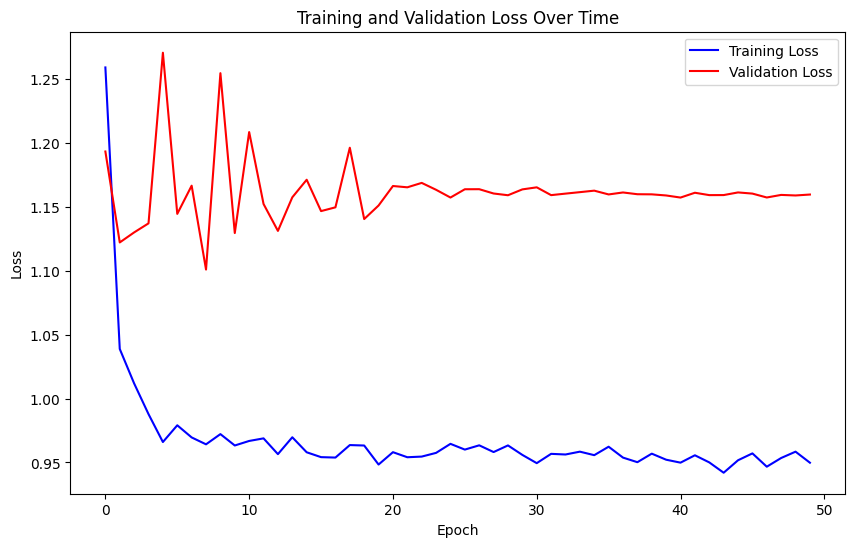

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Hyperparameters
d_model = 32
nhead = 4
num_layers = 6
dim_feedforward = 128
lr = 0.001  # Lower initial learning rate
batch_size = 64
seq_len = 1000
num_epochs = 50

# Initialize the model
device = torch.device('cpu')
model = EEGSeq2SeqPredictor(d_model, nhead, num_layers, dim_feedforward).to(device)

# Count parameters
print(f'The model has {count_parameters(model):,} trainable parameters')

# Initialize model weights
for name, param in model.named_parameters():
    if 'weight' in name:
        if param.dim() >= 2:
            nn.init.kaiming_uniform_(param.data)
    elif 'bias' in name:
        nn.init.constant_(param.data, 0)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

# Placeholder for the best validation loss
best_val_loss = float('inf')

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Main training loop
for epoch in range(num_epochs):
    print("Start of Epoch", epoch + 1)  # Debugging line
    model.train()
    train_loss = 0.0
    train_batches = 0

    for (input_batch_X,), (input_batch_Y,) in zip(train_loader_X, train_loader_Y):
        #print("Batch loaded")  # Debugging line
        optimizer.zero_grad()

        # Debug: Check if input contains NaN or Inf
        if torch.isnan(input_batch_X).any() or torch.isinf(input_batch_X).any():
            print("NaN or Inf found in input, skipping batch")
            continue

        outputs = model(input_batch_X, input_batch_Y[:-1])

        # Debug: Check if output contains NaN or Inf
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("NaN or Inf found in model output, skipping batch")
            continue

        loss = criterion(outputs, input_batch_Y[1:])

        if torch.isnan(loss).any():
            print("NaN loss, stopping training")
            break

        loss.backward()

        # Debug: Print the gradient norms
        #for name, param in model.named_parameters():
        #    if param.grad is not None:
        #        print(f"{name}: Gradient Norm: {torch.norm(param.grad)}")

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        train_loss += loss.item()
        train_batches += 1

    avg_train_loss = train_loss / train_batches

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_batches = 0

    for (input_batch_X,), (input_batch_Y,) in zip(val_loader_X, val_loader_Y):
        input_batch_X, input_batch_Y = input_batch_X.to(device), input_batch_Y.to(device)

        with torch.no_grad():
            outputs = model(input_batch_X, input_batch_Y[:-1])
            batch_loss = criterion(outputs, input_batch_Y[1:])
            val_loss += batch_loss.item()
            val_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches

    # Store the average losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


    # Print current learning rate, average training loss, and average validation loss
    for param_group in optimizer.param_groups:
        print(f"Current learning rate is: {param_group['lr']}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}")
    
    # Update learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Save the model if it's the best one so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/home/vincent/AAA_projects/MVCS/Neuroscience/Models/Test Validation/best_model.pth')

    # Check if learning rate is too small
    for param_group in optimizer.param_groups:
        if param_group['lr'] < 1e-10:
            print("Learning rate too small, stopping training")
            break

    if torch.isnan(loss).any():
        print("Stopping training due to NaN loss")
        break

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [159]:
from torchsummary import summary

# Assuming your model and input size is already defined
summary(model, input_size=(64, 1000, 352))  # Replace input_size with the actual input size
# Assuming attention_weights is a tensor containing the attention map
plt.imshow(attention_weights.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# Assuming attention_weights is a tensor containing the attention map
plt.imshow(attention_weights.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()


TypeError: EEGSeq2SeqPredictor.forward() missing 1 required positional argument: 'tgt'

# second version


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class EEGSeq2SeqPredictor(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(EEGSeq2SeqPredictor, self).__init__()

        # Input transformations
        self.input_batch_X = nn.Linear(352, d_model)
        self.input_batch_Y = nn.Linear(32, d_model)

        # Define encoder and decoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)

        # Final output layer
        self.fc = nn.Linear(d_model, 32)
        
    def forward(self, src, tgt):
        # Apply transformations and positional encoding
        src = self.input_batch_X(src)
        tgt = self.input_batch_Y(tgt)
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        
        # Forward pass through encoder and decoder
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        
        # Generate final output
        output = self.fc(output)
        
        return output

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Hyperparameters
d_model = 128
nhead = 4
num_layers = 3
dim_feedforward = 512
lr = 0.001 
batch_size = 64
seq_len = 1000
num_epochs = 50

# Initialize the model
device = torch.device('cpu')  # or 'cuda' if you have a GPU
model = EEGSeq2SeqPredictor(d_model, nhead, num_layers, dim_feedforward).to(device)

# Count parameters
print(f'The model has {count_parameters(model):,} trainable parameters')

# Initialize model weights
for name, param in model.named_parameters():
    if 'weight' in name:
        if param.dim() >= 2:
            nn.init.kaiming_uniform_(param.data)
    elif 'bias' in name:
        nn.init.constant_(param.data, 0)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Placeholder for the best validation loss
best_val_loss = float('inf')

# Initialize lists to store loss values
train_losses = []
val_losses = []

The model has 1,442,080 trainable parameters


In [18]:
import time
import matplotlib.pyplot as plt

# Function to calculate time taken for each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_val_loss = float('inf')
train_losses = []
val_losses = []

# Main training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Start time tracking
    print(f"Start of Epoch {epoch + 1}")
    model.train()

    train_loss = 0.0
    train_batches = 0
    val_loss = 0.0
    val_batches = 0

    # Training loop
    for (input_batch_X,), (input_batch_Y,) in zip(train_loader_X, train_loader_Y):
        input_batch_X, input_batch_Y = input_batch_X.to(device), input_batch_Y.to(device)
        optimizer.zero_grad()

        outputs = model(input_batch_X, input_batch_Y[:-1])  # Encoding should be inside the model's forward()

        # Debug: Check if input contains NaN or Inf
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("NaN or Inf found in model output, skipping batch")
            continue

        loss = criterion(outputs, input_batch_Y[1:])

        if torch.isnan(loss).any():
            print("NaN loss, stopping training")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1

    # Validation loop
    model.eval()
    for (input_batch_X,), (input_batch_Y,) in zip(val_loader_X, val_loader_Y):
        input_batch_X, input_batch_Y = input_batch_X.to(device), input_batch_Y.to(device)

        with torch.no_grad():
            outputs = model(input_batch_X, input_batch_Y[:-1])
            batch_loss = criterion(outputs, input_batch_Y[1:])
            val_loss += batch_loss.item()
            val_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches

    end_time = time.time()  # End time tracking
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tAverage Training Loss: {avg_train_loss:.4f} | Average Validation Loss: {avg_val_loss:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    scheduler.step()

    for param_group in optimizer.param_groups:
        print(f"Current learning rate is: {param_group['lr']}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")

    if param_group['lr'] < 1e-10:
        print("Learning rate too small, stopping training")
        break

    if torch.isnan(loss).any():
        print("Stopping training due to NaN loss")
        break

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

Start of Epoch 1
NaN or Inf found in model output, skipping batch
Epoch: 01 | Time: 5m 56s
	Average Training Loss: 1.2185 | Average Validation Loss: 1.1684
Current learning rate is: 0.00095
New best model saved with validation loss: 1.1684
Start of Epoch 2
NaN or Inf found in model output, skipping batch
Epoch: 02 | Time: 5m 57s
	Average Training Loss: 1.0432 | Average Validation Loss: 1.0628
Current learning rate is: 0.0009025
New best model saved with validation loss: 1.0628
Start of Epoch 3


KeyboardInterrupt: 

In [ ]:
from torchsummary import summary

# Assuming your model and input size is already defined
summary(model, input_size=(64, 1000, 352))  # Replace input_size with the actual input size
# Assuming attention_weights is a tensor containing the attention map
plt.imshow(attention_weights.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# Assuming attention_weights is a tensor containing the attention map
plt.imshow(attention_weights.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [43]:
print("Shape of outputs tensor:", outputs.shape)

Shape of outputs tensor: torch.Size([63, 1000, 32])


In [44]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Get shape of EEG data
n_timepoints, n_channels = EEG_data.shape

# Standardize the EEG data
scaler = StandardScaler()
scaler.fit(EEG_data)
scaled_EEG_data = scaler.transform(EEG_data)

# Convert scaled EEG data back to PyTorch tensor
eeg_data_scaled_tensor = torch.tensor(scaled_EEG_data, dtype=torch.float32)

# Assuming 'outputs' is a PyTorch tensor (make sure it's defined)
outputs_numpy = outputs.detach().numpy()

# Reshape it to 2D for inverse_transform
reshaped_outputs = outputs_numpy.reshape(-1, n_channels)

# Use the inverse_transform function to transform the data back to the original scale
outputs_original_scale = scaler.inverse_transform(reshaped_outputs)

# Reshape the output back to its original form
outputs_original_scale = outputs_original_scale.reshape(*outputs_numpy.shape)

# Convert to PyTorch tensor
outputs_original_scale_tensor = torch.tensor(outputs_original_scale, dtype=torch.float32)

# Concatenating the output batches to create a sequence of length 63*1000
concatenated_outputs = outputs_original_scale_tensor.reshape(-1, n_channels)

# Channel names (assuming you have them)
channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Slicing to get only the first five rows of the concatenated output for all channels
first_five_rows = concatenated_outputs[:5, :]

print("\nFirst five rows of inverse-transformed model predicted data after concatenation:")
print(pd.DataFrame(first_five_rows.numpy(), columns=channel_names))

# First five rows of original data
print("\nFirst five rows of original data:")
print(pd.DataFrame(EEG_data[:5, :], columns=channel_names))


First five rows of inverse-transformed model predicted data after concatenation:
            Fp1           Fpz           Fp2           F7          F3  \
0 -20672.759766 -18828.339844 -20954.761719  3551.079346  323.228302   
1 -21132.517578 -19029.441406 -20340.693359  4375.533691 -292.517303   
2 -19742.015625 -18686.410156 -19541.625000  1930.068359  148.522919   
3 -21076.716797 -19088.152344 -20745.003906  2831.171143  229.920288   
4 -19832.384766 -18904.216797 -19724.382812  2873.284668   -5.492308   

            Fz          F4           F8          FC5          FC1  ...  \
0 -9064.795898 -639.312988  3998.711426  8360.379883  6900.372070  ...   
1 -8958.666016 -616.060120  4153.498047  6814.571777  6892.304199  ...   
2 -8874.574219 -585.376587  4090.220459  8151.789551  6671.679199  ...   
3 -8324.306641 -614.059387  4090.848633  8280.093750  7249.967773  ...   
4 -8988.385742 -708.548950  3905.944092  7311.143555  6997.684570  ...   

           CP6           P7           P3

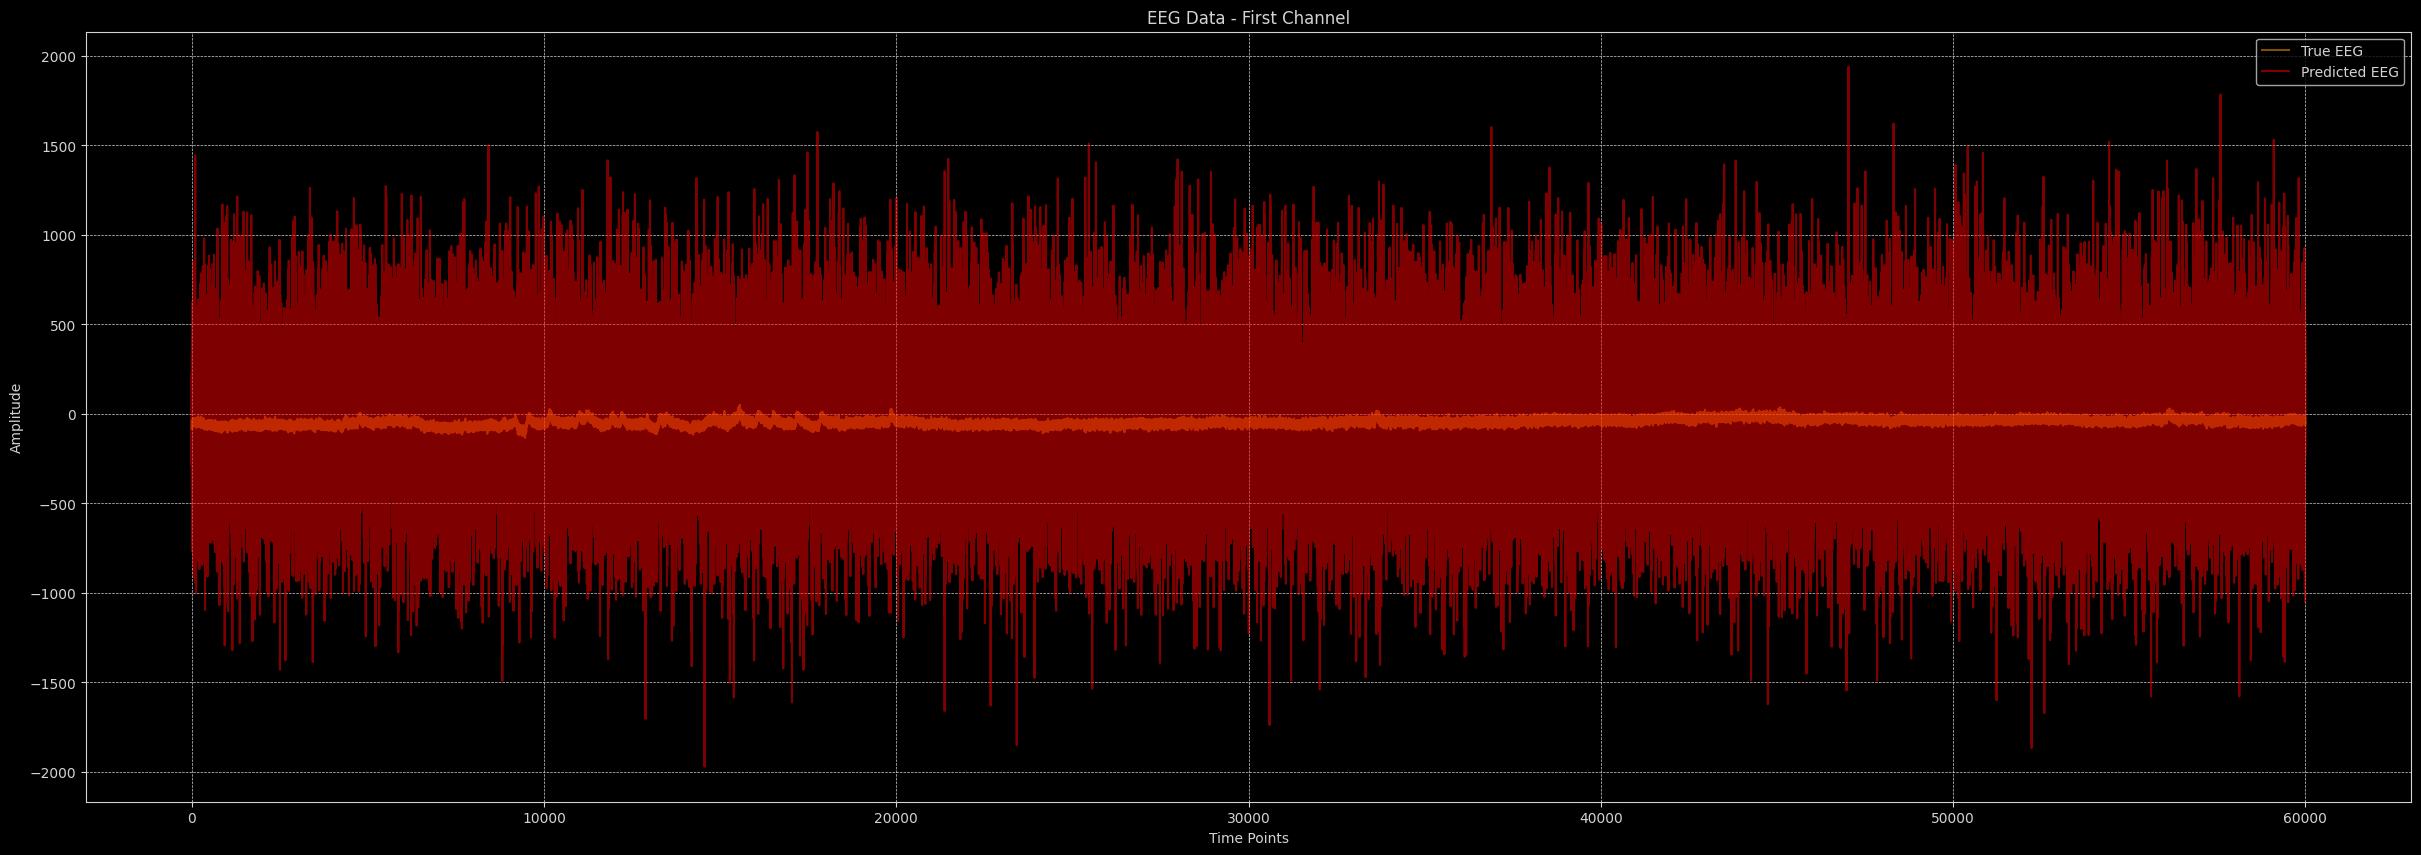

In [160]:
import matplotlib.pyplot as plt

# First ... data points of original data for the first channel
true_data_np = EEG_data[:60000, 4]  # Already a numpy array, first channel

# First ... data points of concatenated, inverse-transformed model predicted data for the first channel
predicted_data_np = concatenated_outputs[:60000, 4]  # We use 'concatenated_outputs_np' array here

# Configure Matplotlib to have a black background and light grey text
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.labelcolor'] = 'lightgrey'
plt.rcParams['text.color'] = 'lightgrey'
plt.rcParams['xtick.color'] = 'lightgrey'
plt.rcParams['ytick.color'] = 'lightgrey'

# Create the plot
plt.figure(figsize=(30, 10), facecolor='black')

# Plotting True EEG Data for the first channel
plt.plot(true_data_np, color='orange', alpha=0.5, label='True EEG')

# Plotting Predicted EEG Data for the first channel
plt.plot(predicted_data_np, color='red', alpha=0.5, label='Predicted EEG')

# Adding title, legend, and axis labels
plt.title('EEG Data - First Channel')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')

# Adding grid lines for better visibility of scale
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')

# Show the plot
plt.show()

# postprocessing

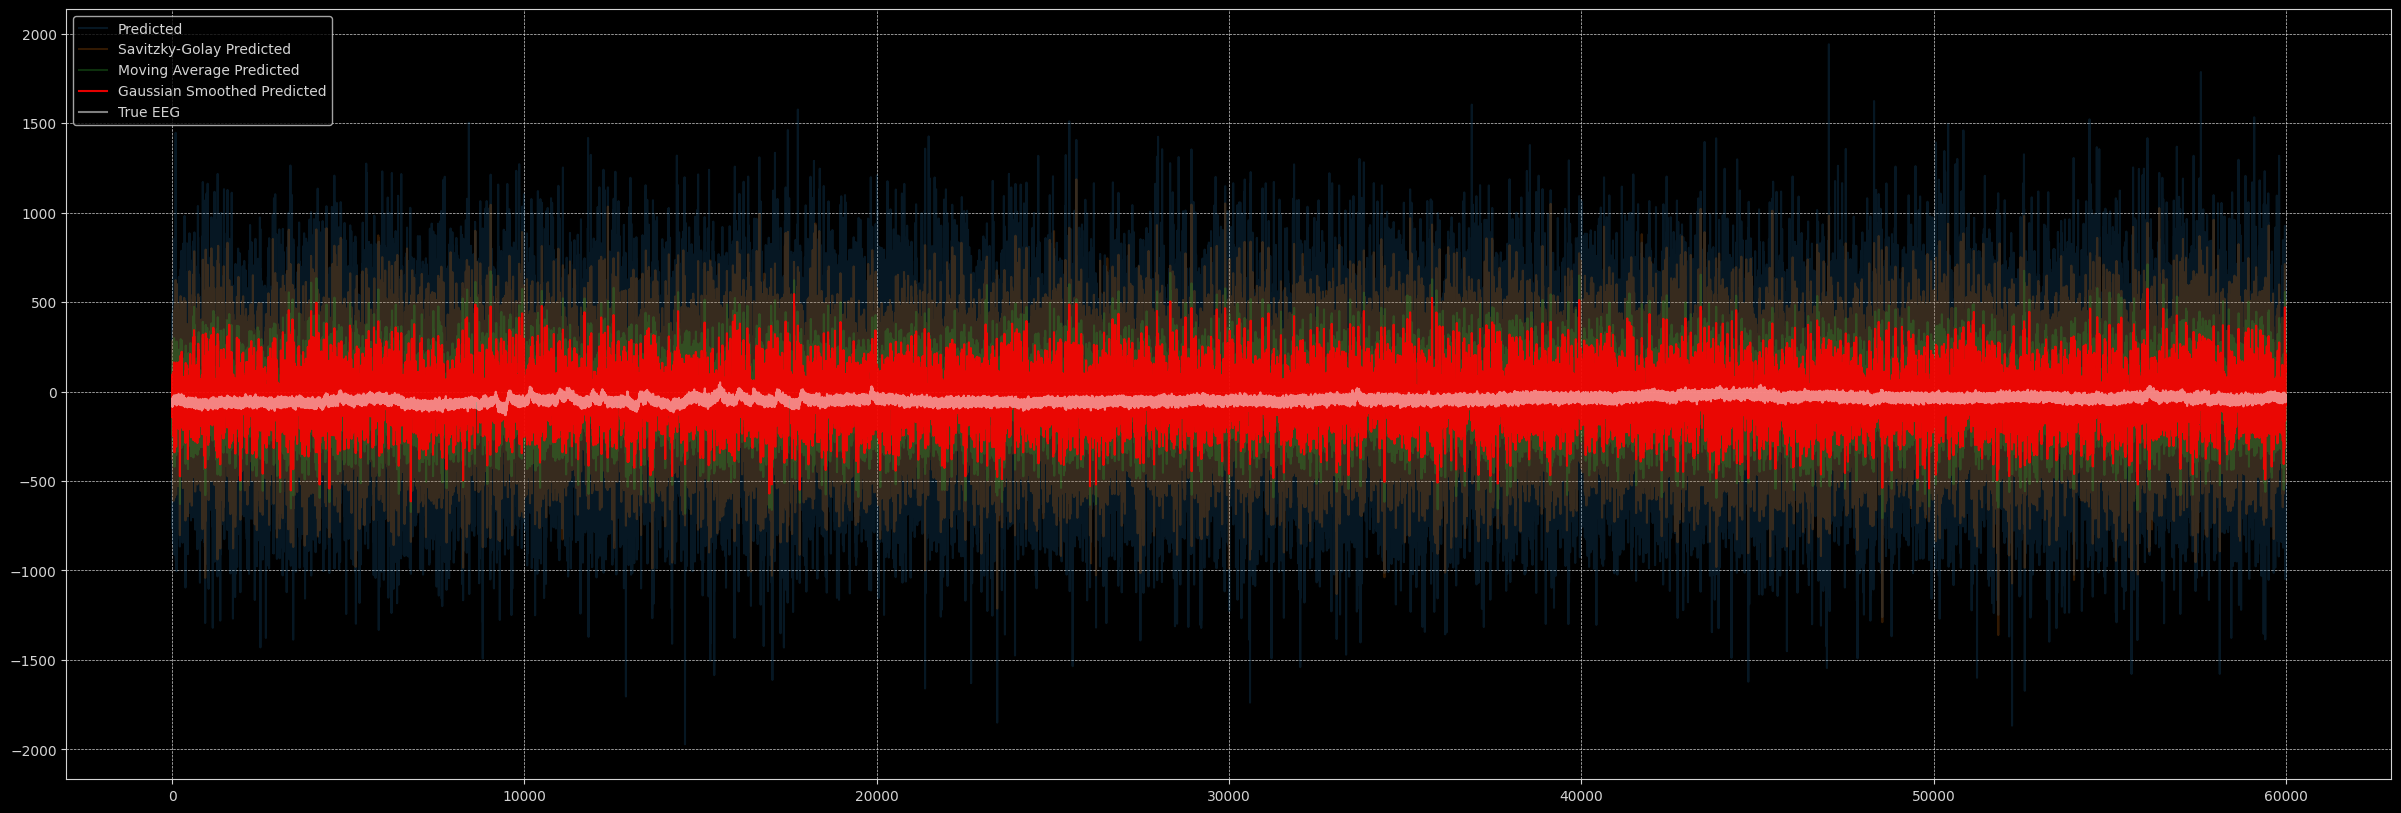

In [166]:
import pandas as pd

predicted_df = pd.DataFrame(predicted_data_np, columns=['Channel_1'])
predicted_df['Smoothed_Moving_Avg'] = predicted_df['Channel_1'].rolling(window=5).mean()

from scipy.ndimage import gaussian_filter

smoothed_gaussian = gaussian_filter(predicted_data_np, sigma=2)

from scipy.signal import savgol_filter

smoothed_savgol = savgol_filter(predicted_data_np, window_length=5, polyorder=2)

import matplotlib.pyplot as plt
# Configure Matplotlib to have a black background and light grey text
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.labelcolor'] = 'lightgrey'
plt.rcParams['text.color'] = 'lightgrey'
plt.rcParams['xtick.color'] = 'lightgrey'
plt.rcParams['ytick.color'] = 'lightgrey'

# Create the plot
plt.figure(figsize=(30, 10), facecolor='black')

plt.plot(predicted_data_np, label="Predicted", alpha=0.2)
plt.plot(smoothed_savgol, label="Savitzky-Golay Predicted", alpha=0.2)
plt.plot(predicted_df['Smoothed_Moving_Avg'], label="Moving Average Predicted", alpha=.3)
plt.plot(smoothed_gaussian, color='red', label="Gaussian Smoothed Predicted", alpha=0.9)
plt.plot(true_data_np, color='white', alpha=0.5, label='True EEG')

# Adding grid lines for better visibility of scale
plt.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')

plt.legend()
plt.show()

In [145]:
import numpy as np

# List of npy paths
npy_paths = [
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/BandPowers_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/combined_fft_psd_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/SpectralEntropy_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/SpectralCentroids_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/welchs_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/STFT_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/PeakFrequencies_x.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy/full_granularity_transfer_entropy_results.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy/regional_transfer_entropy_results.npy",
    "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy/transfer_entropy_hemispheric_avg.npy"
]

# Initialize dictionaries to store the npy files and their shapes
npys = {}
npys_shapes = {}

# Load the npy files into a dictionary and collect their shapes
for path in npy_paths:
    npy_name = path.split('/')[-1].replace('.npy', '')

    data = np.load(path, allow_pickle=True)
    if data.shape == ():  # Check for zero-dimensional arrays
        data = data.item()  # Convert to dictionary or scalar
            
    npys[npy_name] = data

    # Handle the shape differently based on the type of data
    if isinstance(data, dict):
        npys_shapes[npy_name] = "Dictionary with keys: " + str(list(data.keys()))
    else:
        npys_shapes[npy_name] = data.shape

# Print the shapes of all loaded npy files
for name, shape in npys_shapes.items():
    print(f"{name}: {shape}")

BandPowers_x: Dictionary with keys: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
combined_fft_psd_x: Dictionary with keys: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
SpectralEntropy_x: Dictionary with keys: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
welchs_x: (4,)
STFT_x: Dictionary with keys: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
PeakFrequencies_

In [149]:
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import numpy as np

def butter_bandstop_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    
    if len(data) > 3 * max(len(a), len(b)):
        y = filtfilt(b, a, data)
        return y
    else:
        print(f"Data too short to apply band-stop filter for frequency band {lowcut}-{highcut} Hz.")
        return data

fs = 1000

predicted_data_np = predicted_data_np

# Spectral entropy threshold
spectral_entropy_threshold = np.percentile(list(npys['SpectralEntropy_x'].values()), 75)

# Transfer entropy threshold
transfer_entropy_values = []
for val in npys['full_granularity_transfer_entropy_results'].values():
    if isinstance(val, dict):
        transfer_entropy_values.extend(val.values())
    else:
        transfer_entropy_values.append(val)
transfer_entropy_threshold = np.percentile(transfer_entropy_values, 75)

# Spectral entropy as an array for slicing
spectral_entropy_array = np.array([val for key, val in sorted(npys['SpectralEntropy_x'].items())])

# Define frequency bands
frequency_bands = [(i, i + 1) for i in range(int(fs / 2))]

for low, high in frequency_bands:
    spectral_subarray = spectral_entropy_array[low:high] if low < len(spectral_entropy_array) else np.array([0])
    transfer_subarray = np.array(transfer_entropy_values[low:high]) if low < len(transfer_entropy_values) else np.array([0])
    current_spectral_entropy = np.mean(spectral_subarray)
    current_transfer_entropy = np.mean(transfer_subarray)

    if current_spectral_entropy > spectral_entropy_threshold or current_transfer_entropy > transfer_entropy_threshold:
        predicted_data_np = butter_bandstop_filter(predicted_data_np, low, high, fs)

# Plotting
plt.figure(figsize=(30, 10))
plt.plot(predicted_data_np, label="Predicted (Filtered)", alpha=0.5)
plt.plot(true_data_np, label="True", alpha=0.5)
plt.legend()
plt.show()


ValueError: The length of the input vector x must be greater than padlen, which is 33.

In [156]:
import numpy as np
from scipy.signal import istft, stft

# Load the previously saved STFT data from 'STFT_x.npy'
stft_data_dict = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Spectral Analysis/STFT_x.npy", allow_pickle=True).item()

# Define the sampling frequency (fs) and channel names
fs = 1000  # Replace this with the actual sampling frequency if different
channel_names = list(stft_data_dict.keys())  # Assuming channel names are the keys in stft_data_dict

# Initialize a dictionary to store the modified time-domain signals for each channel
predicted_data_modified_stft = {}

# Replace this with your actual predicted time-domain data for each channel
predicted_data_time_domain = {}  # Dummy empty dictionary for now

# Loop through each EEG channel
for channel in channel_names:
    
    # Extract the original STFT data for the current channel
    stft_log_original = stft_data_dict[channel]
    
    # Convert the dB data back to power
    stft_data_original = np.power(10, stft_log_original / 10)
    
    # Inverse STFT to get the original time-domain signal
    _, original_signal = istft(stft_data_original, fs=fs)
    
    # Extract the predicted time-domain data for the current channel (replace this with your actual data)
    predicted_signal = predicted_data_time_domain.get(channel, np.zeros_like(original_signal))  # Dummy zeros for now
    
    # Create a new modified signal based on some condition between original and predicted data
    modified_signal = np.maximum(original_signal, predicted_signal)
    
    # Calculate STFT of the modified signal
    _, _, Zxx_modified = stft(modified_signal, fs=fs, nperseg=fs*2)
    
    # Store the modified STFT data
    stft_log_modified = 10 * np.log10(np.abs(Zxx_modified))
    predicted_data_modified_stft[channel] = stft_log_modified

# At this point, predicted_data_modified_stft contains the modified STFT data for each channel


In [152]:
print(STFT_x[list(STFT_x.keys())[0]])


[[ 40.27901945  43.29048063  43.28785317 ...  42.36033325  42.33499974
   37.06853644]
 [ 39.35955148  40.28244249  40.27744403 ...  39.34691137  39.42114273
   36.52675937]
 [ 36.54919092   8.603578     3.26600537 ...  12.23843448  20.45885866
   34.89871106]
 ...
 [ 10.2731061  -12.98425529 -11.03289046 ... -15.63056347  -0.42828091
    8.90193404]
 [ 10.2638421  -10.41895443 -18.98203293 ... -14.64773741  -0.17291408
    8.90253612]
 [ 10.26053239 -10.29006623 -13.99129227 ... -16.59998548  -0.38464733
    8.90347357]]


In [ ]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Assume `spectral_centroid_true` is the Spectral Centroid frequency for the true data
spectral_centroid_true = 50.0  # Replace with the actual value
predicted_data_modified_centroid = butter_bandpass_filter(predicted_data_np, spectral_centroid_true - 5, spectral_centroid_true + 5, fs=1000)


In [ ]:
from scipy.fft import fft

# Assume `max_power_frequency_true` is the Max Power Frequency for the true data
max_power_frequency_true = 60.0  # Replace with the actual value

# FFT of the predicted data
fft_predicted = fft(predicted_data_np)

# Boost the max power frequency
fft_predicted[int(max_power_frequency_true):(int(max_power_frequency_true) + 2)] *= 1.5
fft_predicted[-(int(max_power_frequency_true) + 2):-int(max_power_frequency_true)] *= 1.5

# Inverse FFT to get time-domain signal
predicted_data_modified_maxpower = np.fft.ifft(fft_predicted)

# Since the output might be complex, take the real part
predicted_data_modified_maxpower = np.real(predicted_data_modified_maxpower)


In [ ]:
# Assuming you have loaded these metrics into variables like so:
# higuchi_fractal_dimensions, hurst_exponents, arnold_tongues_rotation

# Initialize a dictionary to store the modified time-domain signals for each channel
predicted_data_modified_stft = {}

# Loop through each EEG channel
for channel in channel_names:

    # Extract the original STFT data for the current channel
    stft_log_original = stft_data_dict[channel]

    # Convert the dB data back to power
    stft_data_original = np.power(10, stft_log_original / 10)

    # Inverse STFT to get the original time-domain signal
    _, original_signal = istft(stft_data_original, fs=fs)

    # Extract the predicted time-domain data for the current channel
    predicted_signal = predicted_data_time_domain.get(channel, np.zeros_like(original_signal))  # Dummy zeros for now

    # Access the metrics for the current channel
    higuchi = higuchi_fractal_dimensions.get(channel, None)
    hurst = hurst_exponents.get(channel, None)
    arnold = arnold_tongues_rotation.get(channel, None)

    # Create a new modified signal based on some condition between original and predicted data
    # Use higuchi, hurst, and arnold to influence how the signals are combined
    # This is where your advanced logic will go. For now, we use a dummy operation:
    modified_signal = np.maximum(original_signal, predicted_signal)  # This should be replaced by your actual logic

    # Calculate STFT of the modified signal
    _, _, Zxx_modified = stft(modified_signal, fs=fs, nperseg=fs*2)

    # Store the modified STFT data
    stft_log_modified = 10 * np.log10(np.abs(Zxx_modified))
    predicted_data_modified_stft[channel] = stft_log_modified


In [ ]:

# Assuming spectral_edge_frequencies is a dictionary with spectral edge frequencies for each EEG channel

# Initialize a dictionary to store the modified time-domain signals for each channel
predicted_data_modified_stft = {}

# Loop through each EEG channel
for channel in channel_names:

    # Extract the original STFT data for the current channel
    stft_log_original = stft_data_dict[channel]
    
    # Convert the dB data back to power
    stft_data_original = np.power(10, stft_log_original / 10)
    
    # Inverse STFT to get the original time-domain signal
    _, original_signal = istft(stft_data_original, fs=fs)
    
    # Extract the predicted time-domain data for the current channel
    predicted_signal = predicted_data_time_domain.get(channel, np.zeros_like(original_signal))  # Dummy zeros for now

    # Access the spectral edge frequency for the current channel
    edge_frequency = spectral_edge_frequencies.get(channel, None)

    # Assume edge_frequency is between 0 and Nyquist frequency
    # Perform logic to adjust predicted STFT using spectral edge frequency
    # Here we are just making an example, actual logic may be far more complex
    _, _, Zxx_predicted = stft(predicted_signal, fs=fs, nperseg=fs*2)
    frequencies, _, _ = stft(predicted_signal, fs=fs, nperseg=fs*2)

    if edge_frequency:
        mask = frequencies < edge_frequency
        Zxx_predicted[mask, :] = np.zeros_like(Zxx_predicted[mask, :])

    # Here, you could have advanced logic to adjust the predicted_signal based on spectral edge frequency

    # Inverse STFT to get the modified time-domain signal
    _, modified_signal = istft(Zxx_predicted, fs=fs)
    
    # Calculate STFT of the modified signal
    _, _, Zxx_modified = stft(modified_signal, fs=fs, nperseg=fs*2)

    # Store the modified STFT data
    stft_log_modified = 10 * np.log10(np.abs(Zxx_modified))
    predicted_data_modified_stft[channel] = stft_log_modified


In [ ]:
# Assuming eeg_data_original_scale_tensor, predicted_outputs_reshaped, and EEG_data are available

# `eeg_data_original_scale_tensor` is converted to a numpy array
# `predicted_outputs_reshaped` is already a numpy array
true_data_np = eeg_data_original_scale_tensor.numpy()
predicted_data_np = outputs_numpy  # No need to convert
original_data_np = EEG_data

print("True EEG - First Channel | Predicted EEG - First Channel | Original EEG - First Channel")
print("-------------------------------------------------------------------------------------")

for true_value, predicted_value, original_value in zip(true_data_np[:100, 0], predicted_data_np[:100, 0], original_data_np[:100, 0]):
    print(f"{true_value:20} | {predicted_value:20} | {original_value:20}")


In [ ]:
# Load your saved test dataset
test_data = torch.load(test_dataset_path)

# Create DataLoader for test set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Final Evaluation on Test Data
model.eval()
test_loss = 0
with torch.no_grad():
    for time_data, global_data, trans_data, labels in test_loader:
        outputs = model(time_data, global_data, trans_data)
        test_loss += nn.MSELoss()(outputs, labels).item()
        
print(f'Final Test loss: {test_loss / len(test_loader)}')

# If you want to save the model
torch.save(model.state_dict(), '/path/to/save/final_model.pth')

# Real-time training and predictions

In [ ]:
# Record user EEG for one minute

In [ ]:
# Let training finish

In [ ]:
# Wait for one minute of new user EEG data and predict the next minute